# Testing the optimization submodule for 1 dof elements (bars), 1D geometries

  __                _              _ _               
 / _|              | |            | | |              
| |_ ___ _ __ ___  | |_ ___   ___ | | |__   _____  __
|  _/ _ \ '_ ` _ \ | __/ _ \ / _ \| | '_ \ / _ \ \/ /
| ||  __/ | | | | || || (_) | (_) | | |_) | (_) >  < 
|_| \___|_| |_| |_| \__\___/ \___/|_|_.__/ \___/_/\_\
                ______                               
               |______|                              

github.com/Gabbbri/fem_toolbox


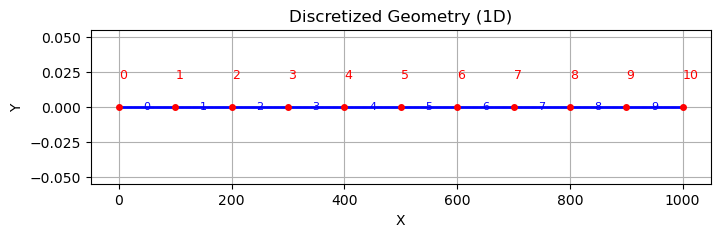

Constraint check passed: 1 DOFs constrained out of 11.


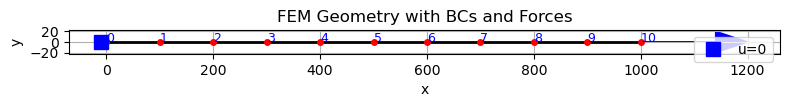

In [1]:
import fem_toolbox as ft

# read geometry

nodes_coords_beam, beam_connectivity, beam_crossSections, mat_properties = ft.geometry.read_structure("../shape_optimization/geom/myrod.txt")

# meshing
elements_per_beam = 10

fem_nodes, fem_elements, element_crossSections = ft.mesh.discretize(nodes_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=elements_per_beam)

ft.mesh.plot_discretized_geometry_1D(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

ndof_per_node = 1

# BC and forces
_ , bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = ft.BC_loads.read_bc_and_forces("../shape_optimization/geom/myrodBC.txt")

# validate constraints (read docs)
num_nodes= fem_nodes.shape[0]
ft.BC_loads.validate_constraints(num_nodes, ndof_per_node, bc_nodes, bc_dofs)

# visual validation before solving 
ft.BC_loads.plot_fem_model(fem_nodes, fem_elements, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, scale_force=0.2)


In [2]:
# assemble global mass matrix rod
local_m_matrix = ft.elements.m_rod
local_k_matrix = ft.elements.k_rod
rotation_matrix = None 

M_global = ft.femsolver.assembleM(local_m_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

K_global = ft.femsolver.assembleK(local_k_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

# assemble global force vector
num_dofs = M_global.shape[0]
f_ext = ft.femsolver.build_force_vector(f_nodes, f_dofs, f_values, num_dofs, ndof_per_node)

# Modal analysis
print(f"\nBoundary conditions: {bc_dofs}\n")

frequencies, mode_shapes, free_dofs = ft.femsolver.modal_analysis(K_global, M_global, bc_nodes, bc_dofs, ndof_per_node, num_modes = 3, verbose=True)

# static analysis (for checking purposes)
u = ft.femsolver.static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)

print(f"\nNodal displacements: {u}")

# post processing stresses
cross_section = "circular"

stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_rod, None, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node=1)

print(stress_axial)


Boundary conditions: [0]

Mode 1: 40.93 Hz
Mode 2: 123.81 Hz
Mode 3: 209.74 Hz

Nodal displacements: [0.         0.00146972 0.00293945 0.00440917 0.00587889 0.00734862
 0.00881834 0.01028807 0.01175779 0.01322751 0.01469724]
[3.08641975 3.08641975 3.08641975 3.08641975 3.08641975 3.08641975
 3.08641975 3.08641975 3.08641975 3.08641975]


## Optimization 1: 
**OBJECTIVE: weight minimization**

**CONSTRAINTS: stresses**

In [3]:
sigma_max = 20

# optimize
optim_areas_stress = ft.optimizer.optimize_crossSections4stress_trusses(element_crossSections, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, ft.femsolver.assembleK, ft.femsolver.build_force_vector, local_k_matrix, None)


# check
ft.optimizer.checkOptimization_stresses_trusses(element_crossSections, optim_areas_stress, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_ext, f_nodes, f_dofs, ft.femsolver.assembleK, ft.femsolver.build_force_vector, local_k_matrix, rotation_func=None)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 49999.99999905643
            Iterations: 12
            Function evaluations: 125
            Gradient evaluations: 11
Element  | Area (orig) | Area (opt) | Stress (orig) | Stress (opt) | max_stress
---------|-------------|------------|----------------|----------------|----------
   0     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   1     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   2     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   3     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   4     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   5     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   6     |   324.00    |   50.00    |      3.09      |     20.00      |     20.00
   7     |   324.00    |   50.00    |      3.09      |

## Optimization 2 
**OBJECTIVE: weight minimization**

**CONSTRAINTS: forbidden frequency band**

Not always the optimizer converges to a good solution. If **optimizer exit mode is not 0**, please run again the function. 

Also if there are big area differences between consecutive elements (the optimization procedure penalizes such cases, but they can still happen), run again the function

In [4]:
forbidden_frequency_band = (35, 60)     # Hz

_, optim_areas_freq = ft.optimizer.optimize_crossSections4frequency_trusses(element_crossSections, forbidden_frequency_band, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, ft.femsolver.assembleK, ft.femsolver.assembleM, 4, ft.elements.k_rod, ft.elements.m_rod, None, A_min = 50, A_max=200)

# check
ft.optimizer.checkOptimization_frequencies_trusses(
    element_crossSections,
    optim_areas_freq,
    forbidden_frequency_band,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node=1,
    bc_nodes=bc_nodes,
    bc_dofs=bc_dofs,
    assembleK=ft.femsolver.assembleK,
    assembleM=ft.femsolver.assembleM,
    k_local_func=ft.elements.k_rod,
    m_local_func=ft.elements.m_rod,
    num_modes=5,
    verbose=True,
)

# IF THERE ARE BIG DIFFERENCES IN AREA BETWEEN DIFFERENT ELEMENTS, RUN AGAIN THE OPTIMIZATION. SOME SMOOTHNESS BETWEEN CROSS SECTIONS SHOULD BE PRESENT. YOU CAN ALSO PLAY AROUND WITH THE PENALIZATION PARAMETERS A BIT 

[57.13217955 50.         50.         53.65462171 50.         50.
 58.79578659 50.         54.71113216 51.04491209]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1984.6837360614145
            Iterations: 678
            Function evaluations: 9846
            Gradient evaluations: 676

Element-wise Area Comparison:
Element | Area (original) | Area (optimized)
--------|------------------|------------------
   0     |      324.00      |      118.09     
   1     |      324.00      |      189.66     
   2     |      324.00      |      71.00      
   3     |      324.00      |      84.09      
   4     |      324.00      |      121.58     
   5     |      324.00      |      109.89     
   6     |      324.00      |      156.78     
   7     |      324.00      |      131.91     
   8     |      324.00      |      181.64     
   9     |      324.00      |      200.00     

Forbidden frequency band
    f_min = 35
    f_max = 60


Modal Frequencies Co

### Wrapper for the frequency optimization

It can happen that the frequency constrained optimization doesn't terminate with a good solution. Instead of letting the user check and manually recall the function, this wrapper iterates until a good solution is found

In [5]:
print(fem_elements, fem_nodes)

[[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 5  6]
 [ 6  7]
 [ 7  8]
 [ 8  9]
 [ 9 10]] [[   0.    0.]
 [ 100.    0.]
 [ 200.    0.]
 [ 300.    0.]
 [ 400.    0.]
 [ 500.    0.]
 [ 600.    0.]
 [ 700.    0.]
 [ 800.    0.]
 [ 900.    0.]
 [1000.    0.]]


In [6]:
optim_areas_freq, best_hparams = ft.optimizer.optimizeFrequency_random_hyperparameter_search(
    max_trials=30,
    element_crossSections=element_crossSections,
    forbidden_range=forbidden_frequency_band,
    fem_nodes=fem_nodes,
    fem_elements=fem_elements,
    mat_properties=mat_properties,
    ndof_per_node=ndof_per_node,
    bc_nodes=bc_nodes,
    bc_dofs=bc_dofs,
    bc_values=bc_values,
    assembleK=ft.femsolver.assembleK,
    assembleM=ft.femsolver.assembleM,
    num_modes=5,
    k_local_func=ft.elements.k_rod,
    m_local_func=ft.elements.m_rod,
    rotation_func=None,
    A_min=50,
    A_max=200
)



[Trial 1] Trying with:
  Uniformity penalty: 0.3282
  Smoothness penalty: 0.1421
  Boundary penalty:   350.08
[50.         50.         50.         50.         50.         52.7523368
 50.         54.57985249 59.14520339 50.        ]
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 2614.1399314895034
            Iterations: 258
            Function evaluations: 3964
            Gradient evaluations: 254

	              Optimization was not successfull. Please try again

❌ Trial 1 failed: Positive directional derivative for linesearch

[Trial 2] Trying with:
  Uniformity penalty: 0.2753
  Smoothness penalty: 0.1796
  Boundary penalty:   296.37
[50.         58.09104704 57.25421873 51.63336934 54.96377034 51.22409754
 50.         55.87790596 55.85659923 51.09573594]
Iteration limit reached    (Exit mode 9)
            Current function value: 807.6052240188401
            Iterations: 1000
            Function evaluations: 14393
            

In [7]:
print(optim_areas_freq)


ft.optimizer.checkOptimization_frequencies_trusses(
    element_crossSections,
    optim_areas_freq,
    forbidden_frequency_band,
    fem_nodes,
    fem_elements,
    mat_properties,
    ndof_per_node=1,
    bc_nodes=bc_nodes,
    bc_dofs=bc_dofs,
    assembleK=ft.femsolver.assembleK,
    assembleM=ft.femsolver.assembleM,
    k_local_func=ft.elements.k_rod,
    m_local_func=ft.elements.m_rod,
    num_modes=5,
    verbose=True,
)

[199.30988266 107.6912704   50.55439396  50.51284374  50.15764508
  50.99999997  50.09671182  50.26466803 189.49608269 101.20659326]

Element-wise Area Comparison:
Element | Area (original) | Area (optimized)
--------|------------------|------------------
   0     |      324.00      |      199.31     
   1     |      324.00      |      107.69     
   2     |      324.00      |      50.55      
   3     |      324.00      |      50.51      
   4     |      324.00      |      50.16      
   5     |      324.00      |      51.00      
   6     |      324.00      |      50.10      
   7     |      324.00      |      50.26      
   8     |      324.00      |      189.50     
   9     |      324.00      |      101.21     

Forbidden frequency band
    f_min = 35
    f_max = 60


Modal Frequencies Comparison:
Mode    | Frequency (orig) | Frequency (opt)
--------|------------------|-----------------
   1     |     40.9318      |     35.0100    
   2     |     123.8073     |    130.1888    
   

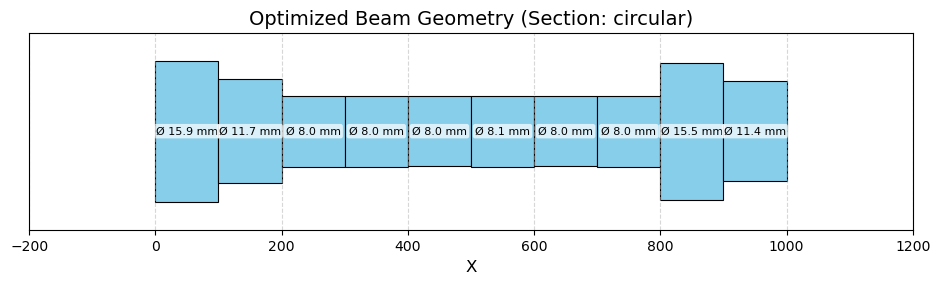

In [8]:
ft.optimizer.optim_plot_1D_beam_geometry(
    fem_nodes,
    fem_elements,
    optim_areas_freq,
    section_shape="circular",  # or "rectangle"
    show_labels=True
)
